In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.utils.data import DataLoader, sampler
import matplotlib.pyplot as plt
import os
import copy
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score

In [2]:
data_transforms = {
    'seg_train/seg_train': transforms.Compose([
        transforms.RandomResizedCrop(112),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'seg_test/seg_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(112),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'seg_pred': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(112),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'intel_places_ds'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['seg_train/seg_train', 'seg_test/seg_test', 'seg_pred']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True)
              for x in ['seg_train/seg_train', 'seg_test/seg_test', 'seg_pred']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['seg_train/seg_train', 'seg_test/seg_test', 'seg_pred']}
class_names = image_datasets['seg_train/seg_train'].classes

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(base_model, criterion_loss, optimizer, num_epochs=5):

    best_model_wts = copy.deepcopy(base_model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0

        train_acc = 0
        test_acc = 0

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        base_model.train()

        for img, labels in dataloaders['seg_train/seg_train']:
            img, labels = img.cuda(), labels.cuda()
            img = img.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = base_model(img)
            loss = criterion_loss(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
            train_acc += accuracy.item() * img.size(0)
    
        base_model.eval()

        for img, labels in dataloaders['seg_test/seg_test']:
            img, labels = img.cuda(), labels.cuda()
            img = img.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = base_model(img)
            loss = criterion_loss(output, labels)
            loss.backward()
            optimizer.step()
            test_loss += loss.item() * img.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
            test_acc += accuracy.item() * img.size(0)
    
        train_loss = train_loss / len(dataloaders['seg_train/seg_train'].dataset)
        test_loss = test_loss / len(dataloaders['seg_test/seg_test'].dataset)

        train_acc = train_acc / len(dataloaders['seg_train/seg_train'].dataset)
        test_acc = test_acc / len(dataloaders['seg_test/seg_test'].dataset)


        print("Training Loss: {:.3f}, Training Accuracy: {:.3f}".format(train_loss, train_acc))
        print("Testing Loss: {:.3f}, Testing Accuracy: {:.3f}".format(test_loss, test_acc))
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(base_model.state_dict())
    
    print("Best accuracy: {:.3f}".format(best_acc))

    base_model.load_state_dict(best_model_wts)
    return base_model

In [4]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_classes = 6
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

if torch.cuda.is_available():
    model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [5]:
torch.cuda.memory_summary(device, abbreviated=False)
torch.cuda.empty_cache()
torch.ones((1500*2**18)).cuda(device).contiguous()
model = model.to(device)

In [6]:
#torch.utils.checkpoints

In [7]:
model = train_model(model, criterion, optimizer)

Epoch 1/5
----------
Training Loss: 0.486, Training Accuracy: 0.814
Testing Loss: 0.408, Testing Accuracy: 0.849
Epoch 2/5
----------
Training Loss: 0.421, Training Accuracy: 0.838
Testing Loss: 0.357, Testing Accuracy: 0.867
Epoch 3/5
----------
Training Loss: 0.419, Training Accuracy: 0.837
Testing Loss: 0.333, Testing Accuracy: 0.872
Epoch 4/5
----------
Training Loss: 0.420, Training Accuracy: 0.843
Testing Loss: 0.315, Testing Accuracy: 0.882
Epoch 5/5
----------
Training Loss: 0.409, Training Accuracy: 0.841
Testing Loss: 0.295, Testing Accuracy: 0.889
Best accuracy: 0.889


In [8]:
def predict():
    test_acc = 0
    test_acc = 0
    real_lab = torch.tensor([]).to(device)
    pred_lab = torch.tensor([]).to(device)
    tr_pred =  []

    for batch, (X, y) in enumerate(dataloaders['seg_test/seg_test']):
        X, y = X.to(device), y.to(device)
        real_lab = torch.cat((real_lab, y), 0)
        pred = model(X)
        _, pred = torch.max(pred, dim=1)
        pred_lab = torch.cat((pred_lab, pred), 0)

        correct_tensor = pred.eq(y.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
        test_acc += accuracy.item()* X.size(0)
    
    test_acc = test_acc / len(dataloaders['seg_test/seg_test'].dataset)
    print(f'    Testing Accuracy: { test_acc:.2f}')
    return pred_lab.cpu().numpy(),  real_lab.cpu().numpy()

all_pr,  real_lab = predict()

    Testing Accuracy: 0.91


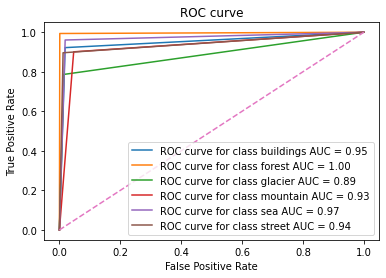

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
lab_plt = [(real_lab == i).astype(float) for i in range(6)]
outs_plt = [(all_pr == i).astype(float) for i in range(6)]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(lab_plt[i], outs_plt[i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.title('ROC curve')
for i in range(6):
    plt.plot(fpr[i], tpr[i], label = f'ROC curve for class {class_names[i]} AUC = {roc_auc[i]:.2f}' )
plt.legend(loc = 'best')
plt.plot([0,1], [0,1], linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [10]:
print(classification_report(real_lab,all_pr, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.89      0.92      0.91       437
      forest       0.99      0.99      0.99       474
     glacier       0.93      0.79      0.85       553
    mountain       0.80      0.90      0.85       525
         sea       0.91      0.96      0.94       510
      street       0.94      0.90      0.92       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



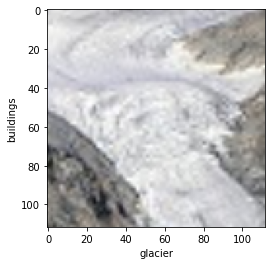

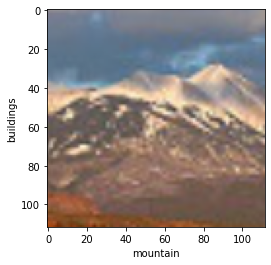

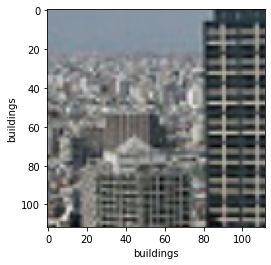

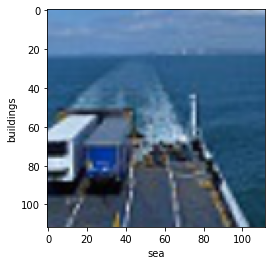

In [12]:
def plot_img(n):
    count = 0
    for img, lab in dataloaders['seg_pred']:
        count += 1 
        image = img 
        img = img.to(device)
        pred = model(img)
        _, pred = torch.max(pred, dim=1)
        for i in range(4):
            inp = torchvision.utils.make_grid(image[i]).numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)
            plt.ylabel(class_names[lab[i]])
            plt.xlabel(class_names[pred[i]])
            plt.show()
        if count == n:
            break

plot_img(1)